# Project Title : Speech Emotion Recognition

Presented by :  

*   AMMOURI Yassire
*   ALLAL Yahia,
*   AIT ICHOU Mustapha
*   AIT-AISSA Mohamed






Introduction

Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

# Install and import libraries


In [15]:
!pip install tensorflow

In [16]:
import librosa
import soundfile
import os
import glob
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import tensorflow as tf
import sklearn.metrics as metrics
import gdown
import zipfile
import IPython.display as ipd
from IPython.display import Audio
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Download the dataset


Here is the filename identifiers of the data:

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong).
*   NOTE: There is no strong intensity for the 'neutral' emotion.
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02)

Speech (01)

Fearful (06)

Normal intensity (01)

Statement "dogs" (02)

1st Repetition (01)

12th Actor (12) - Female (as the actor ID number is even)



In [17]:
# URL du fichier zip
url = "https://drive.google.com/uc?id=1dT1A_sVq3iMFOCxeZVXmiohXOcwA9TXr"

# Téléchargement du fichier zip
output = "emotion_classification.zip"
gdown.download(url, output, quiet=False)

# Vérification du contenu du fichier téléchargé
with open(output, 'rb') as file:
    header = file.read(4)
    print("File header:", header)

# Extraction du fichier zip si le header est valide
if header.startswith(b'PK'):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("emotion_classification")

    # Vérification des fichiers extraits
    print("Fichiers extraits :")
    print(os.listdir("emotion_classification"))
else:
    print("Le fichier téléchargé n'est pas un fichier ZIP valide.")


Downloading...
From (original): https://drive.google.com/uc?id=1dT1A_sVq3iMFOCxeZVXmiohXOcwA9TXr
From (redirected): https://drive.google.com/uc?id=1dT1A_sVq3iMFOCxeZVXmiohXOcwA9TXr&confirm=t&uuid=205f19ee-52e7-4acd-8ab7-79db1119deee
To: /content/emotion_classification.zip
100%|██████████| 78.1M/78.1M [00:03<00:00, 22.3MB/s]


File header: b'PK\x03\x04'
Fichiers extraits :
['Actor_20', 'Actor_19', 'Actor_21', 'Actor_11', 'Actor_06', 'Actor_13', 'Actor_16', 'Actor_02', 'Actor_07', 'Actor_22', 'Actor_05', 'Actor_01', 'Actor_08', 'Actor_14', 'Actor_17', 'Actor_23', 'Actor_10', 'Actor_24', 'Actor_09', 'Actor_15', 'Actor_04', 'Actor_12', 'Actor_18', 'Actor_03']


# Plot exemple d'onde

In [18]:
data_directory ='/content/emotion_classification/'

In [19]:
dataset_repo = os.listdir(data_directory)

file_emotion = []
file_path = []

for dir in dataset_repo:
  actor = os.listdir(data_directory + dir)
  for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(data_directory + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
dataset_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
dataset_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
dataset_df.head(10)

,Emotions,Path
0,angry,/content/emotion_classification/Actor_20/03-01...
1,angry,/content/emotion_classification/Actor_20/03-01...
2,angry,/content/emotion_classification/Actor_20/03-01...
3,disgust,/content/emotion_classification/Actor_20/03-01...
4,sad,/content/emotion_classification/Actor_20/03-01...
5,fear,/content/emotion_classification/Actor_20/03-01...
6,calm,/content/emotion_classification/Actor_20/03-01...
7,disgust,/content/emotion_classification/Actor_20/03-01...
8,sad,/content/emotion_classification/Actor_20/03-01...
9,happy,/content/emotion_classification/Actor_20/03-01...


In [20]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

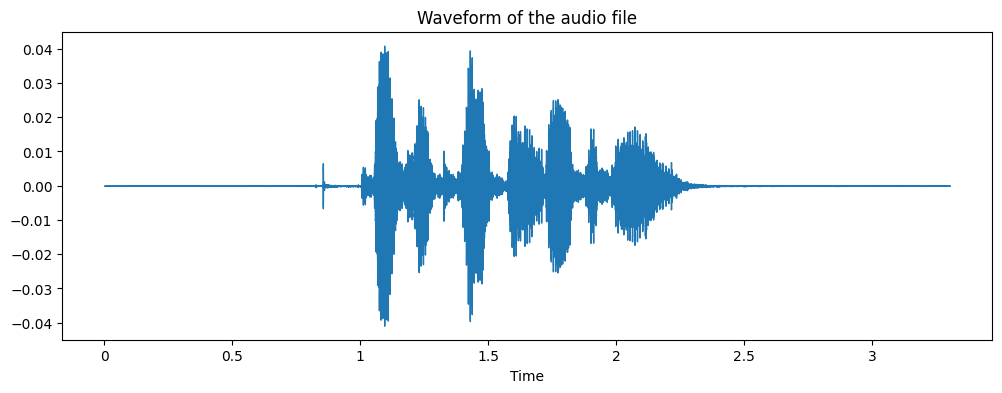

In [21]:
path = '/content/emotion_classification/Actor_01/03-01-01-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
data_directory ='/content/emotion_classification'
# Affichage de la forme d'onde
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title('Waveform of the audio file')
plt.show()
Audio(path)

In [22]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('/content/emotion_classification')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


# Functions

In [23]:

def extract_feature(data, sr, mfcc, chroma, mel):
    """
    Extrait des caractéristiques audio à partir des données audio.

    Args:
        data (np.array): Signal audio.
        sr (int): Taux d'échantillonnage.
        mfcc (bool): Inclure les MFCCs.
        chroma (bool): Inclure les caractéristiques chroma.
        mel (bool): Inclure les caractéristiques Mel.

    Returns:
        np.array: Caractéristiques extraites.
    """
    result = np.array([])

    if chroma:
        stft = np.abs(librosa.stft(data))

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

    if chroma:
        chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, chroma_features))

    if mel:
        # Corrected call: `y` and `sr` should be named arguments
        mel_features = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel_features))

    return result

# Trace les formes d'onde des fichiers audio pour différentes émotions.


In [24]:
# Define observed_emotions and emotions
observed_emotions = ['happy', 'sad', 'angry', 'neutral']  # Example emotions
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

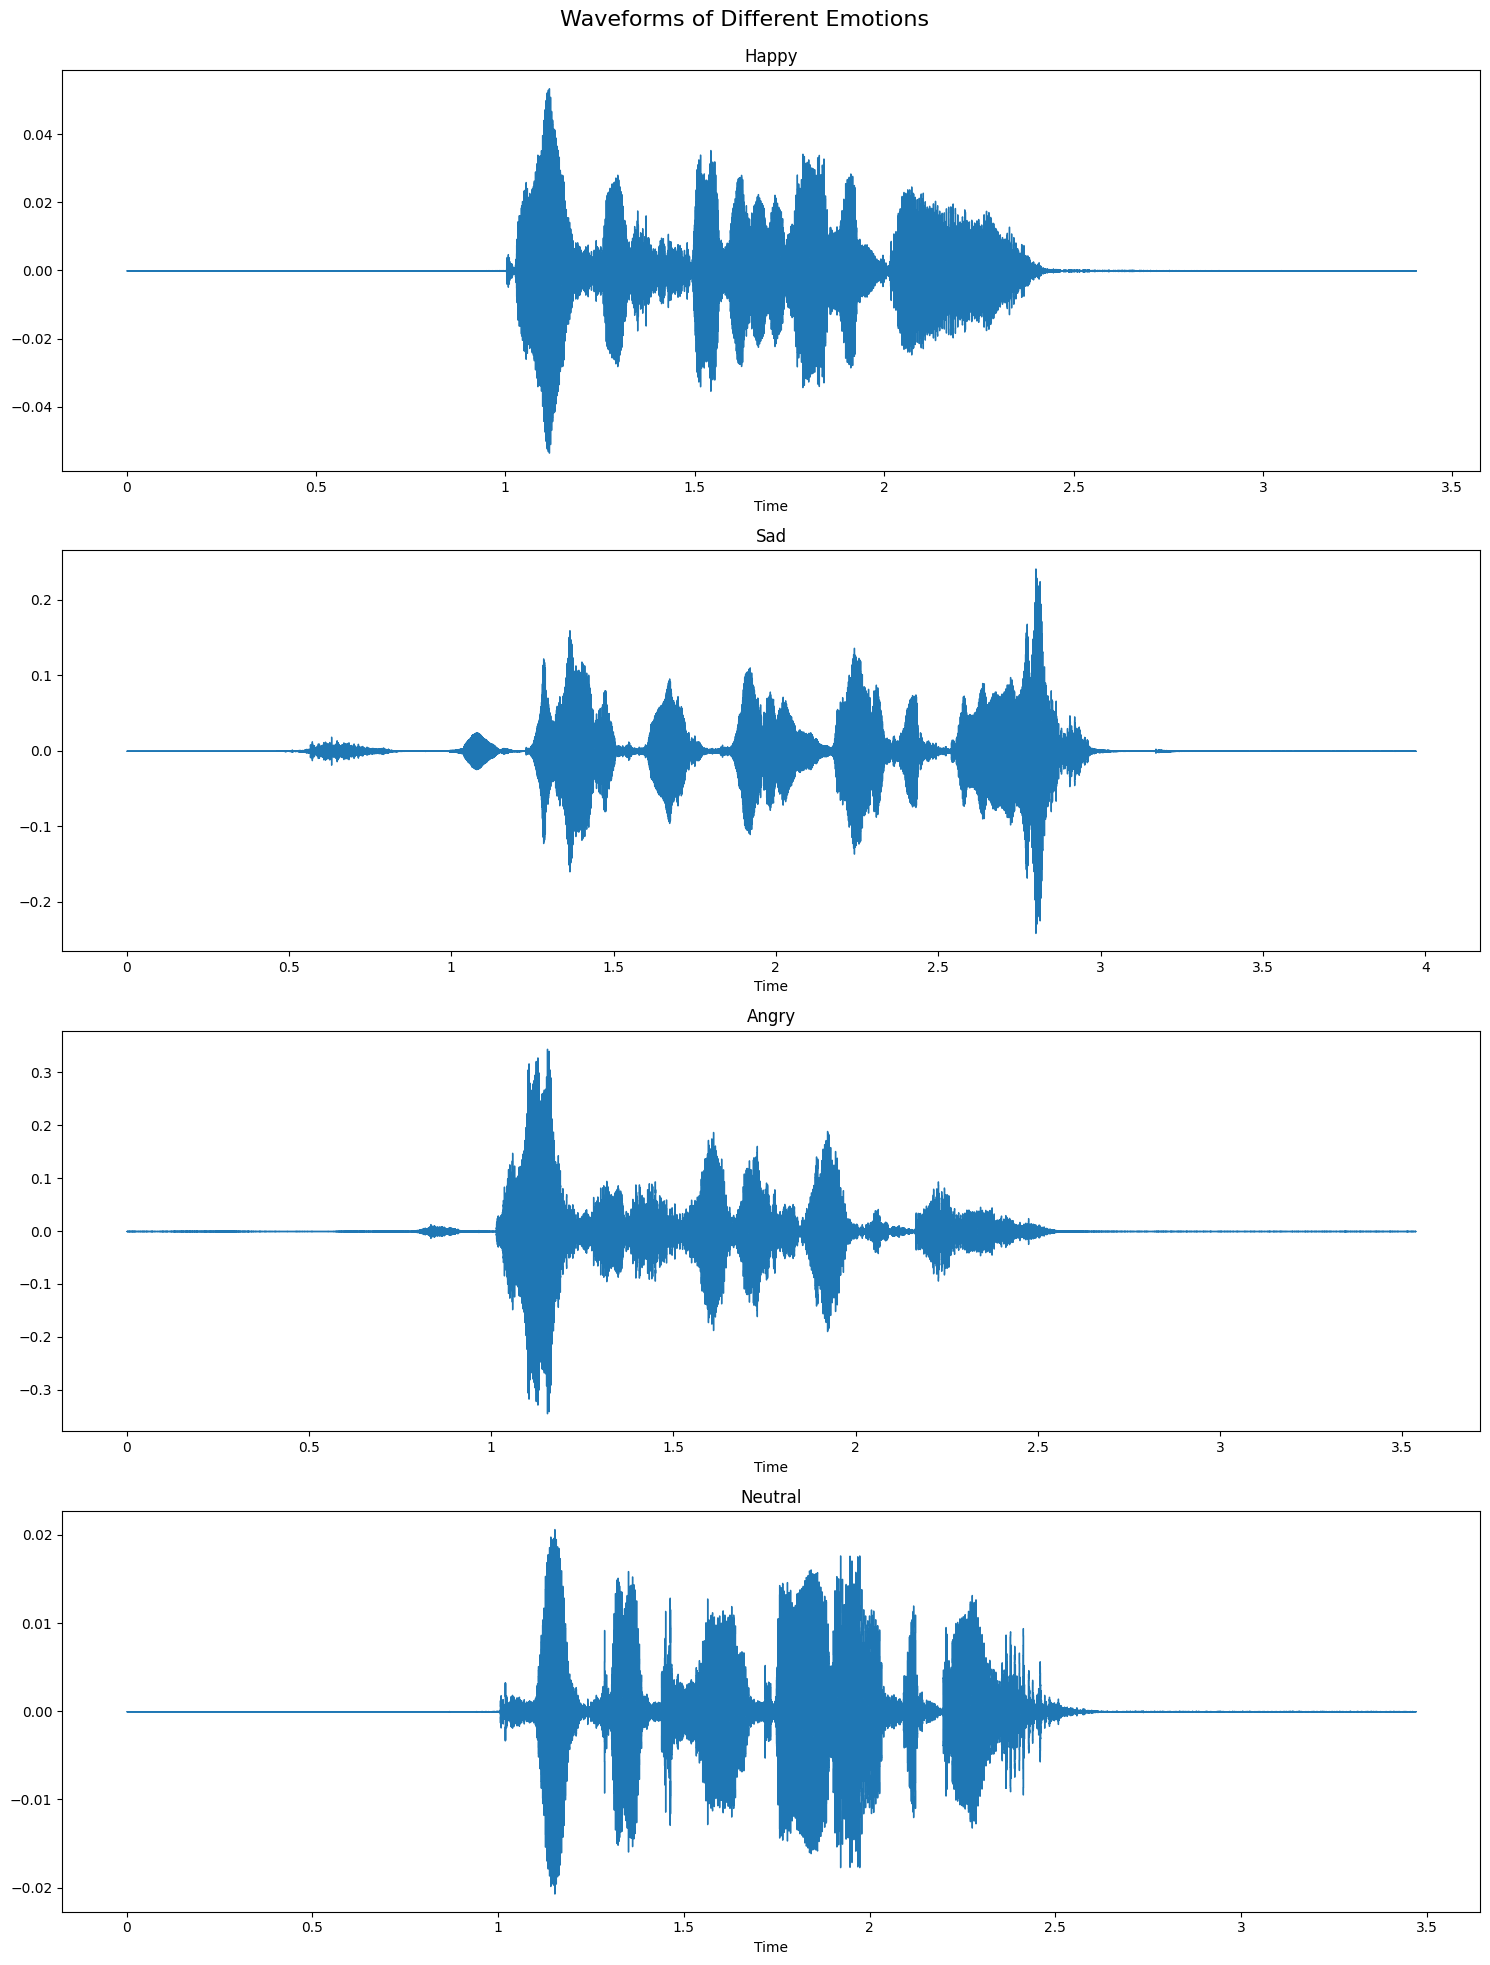

In [25]:

def plot_waveforms():
    fig, axes = plt.subplots(nrows=len(observed_emotions), ncols=1, figsize=(15, 20))
    fig.suptitle('Waveforms of Different Emotions', fontsize=16)
    for i, emotion in enumerate(observed_emotions):
        for file in glob.glob(f'/content/emotion_classification/Actor_*/*.wav'):
            file_name = os.path.basename(file)
            if emotions[file_name.split("-")[2]] == emotion:
                data, sampling_rate = librosa.load(file, sr=None)
                librosa.display.waveshow(data, sr=sampling_rate, ax=axes[i])
                axes[i].set_title(emotion.capitalize())
                break  # Tracer seulement un exemple par émotion
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


# Appel de la fonction pour tracer les formes d'onde
plot_waveforms()

# Visualisation des spectrogrammes pour chaque émotion


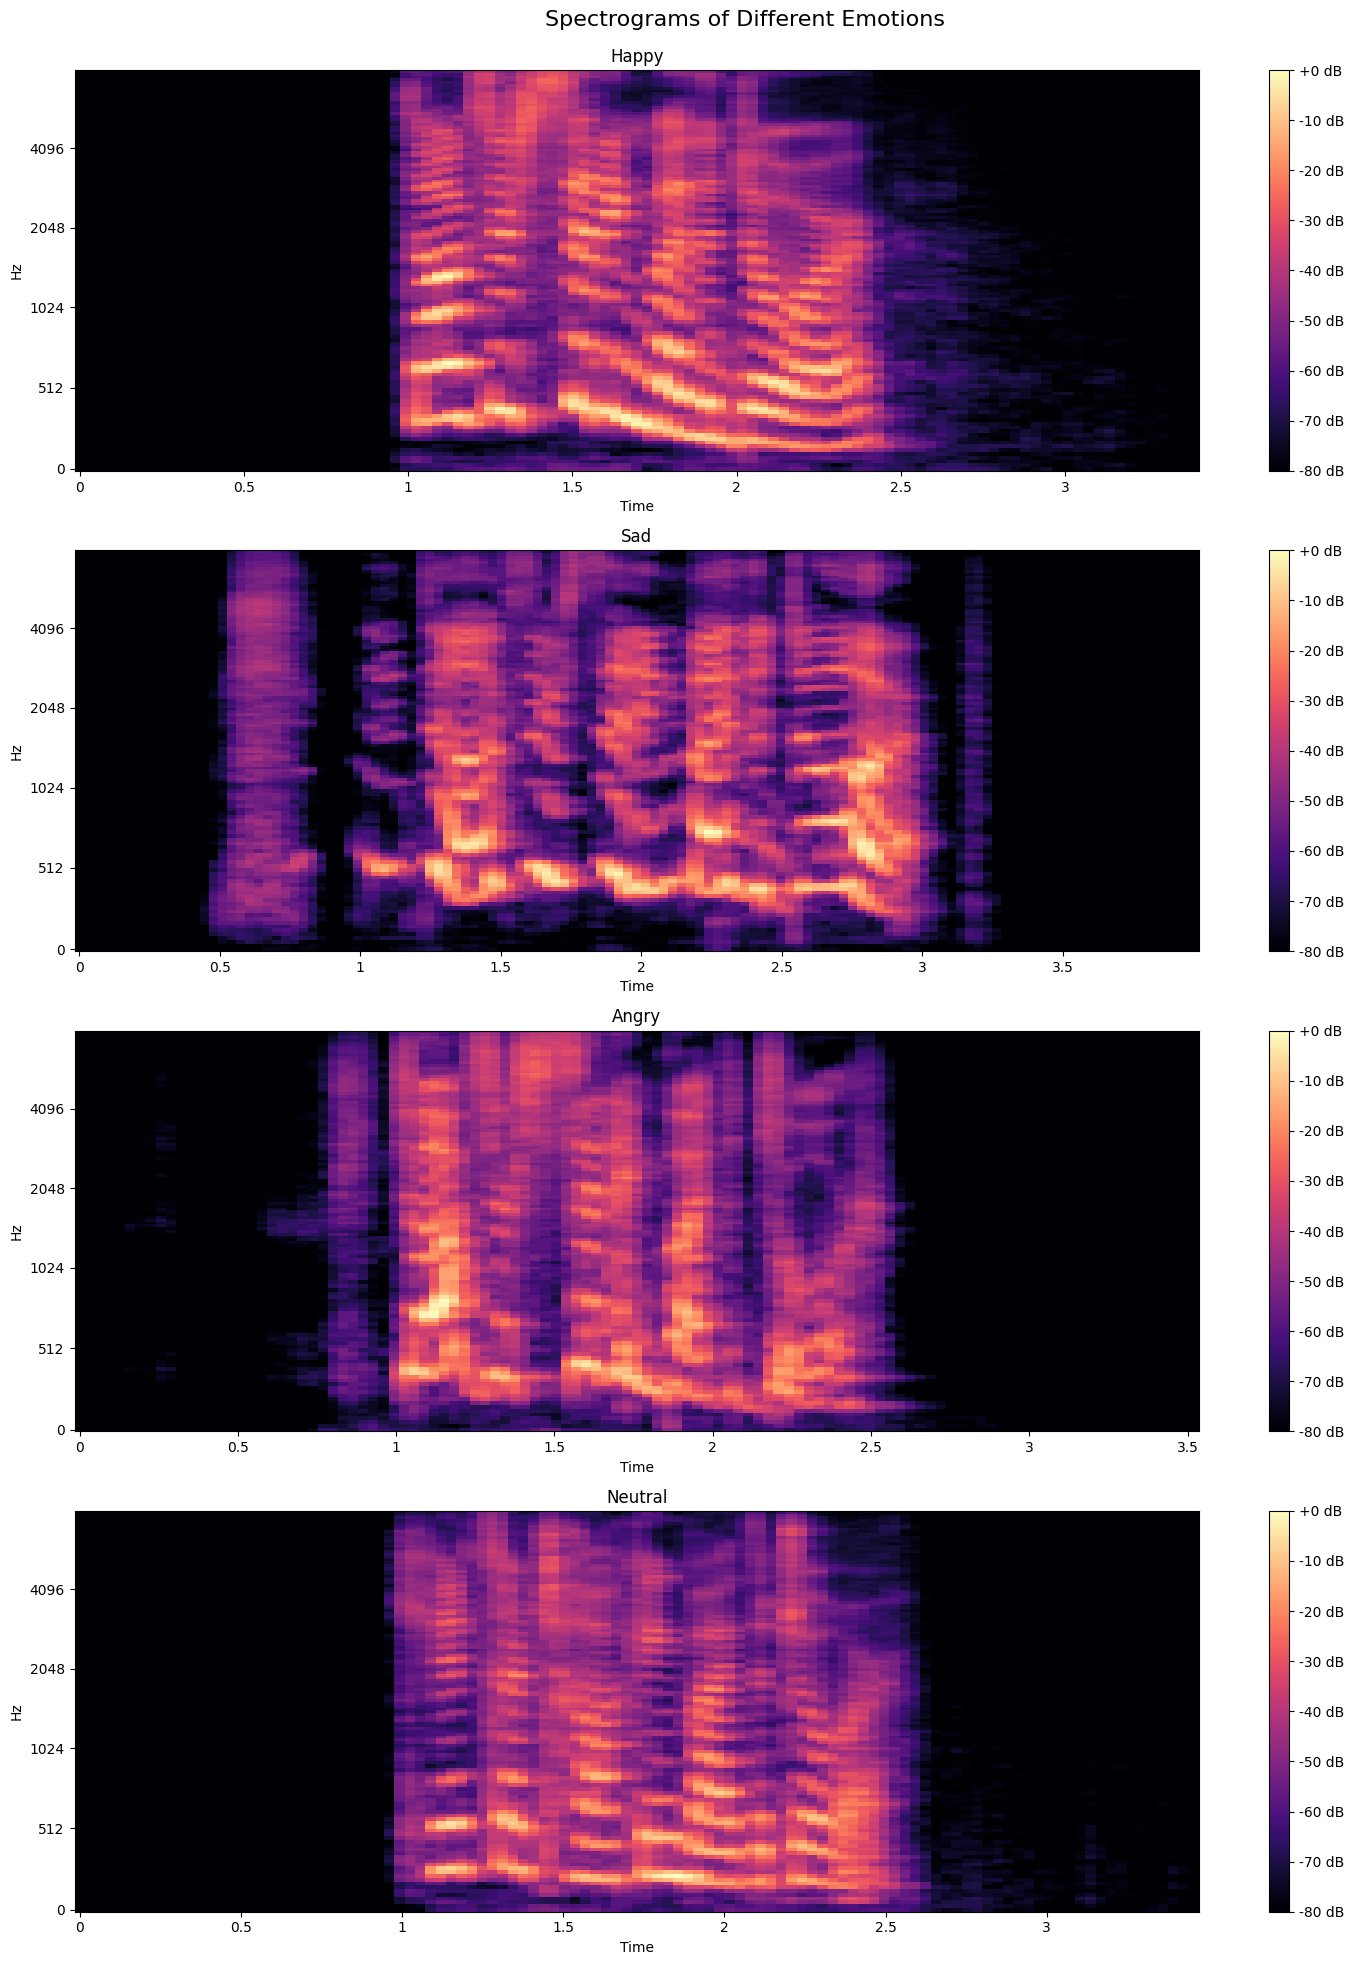

In [26]:
def plot_spectrograms():
    fig, axes = plt.subplots(nrows=len(observed_emotions), ncols=1, figsize=(15, 20))
    fig.suptitle('Spectrograms of Different Emotions', fontsize=16)
    for i, emotion in enumerate(observed_emotions):
        for file in glob.glob(f'/content/emotion_classification/Actor_*/*.wav'):
            file_name = os.path.basename(file)
            if emotions[file_name.split("-")[2]] == emotion:
                data, sampling_rate = librosa.load(file, sr=None)
                S = librosa.feature.melspectrogram(y=data, sr=sampling_rate)
                S_dB = librosa.power_to_db(S, ref=np.max)
                img = librosa.display.specshow(S_dB, sr=sampling_rate, x_axis='time', y_axis='mel', ax=axes[i])
                axes[i].set_title(emotion.capitalize())
                fig.colorbar(img, ax=axes[i], format="%+2.0f dB")
                break  # Tracer seulement un exemple par émotion
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Appel de la fonction pour tracer les spectrogrammes
plot_spectrograms()

## Data augmentation

In [27]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(dataset_df.Path)[1]
data, sample_rate = librosa.load(path)

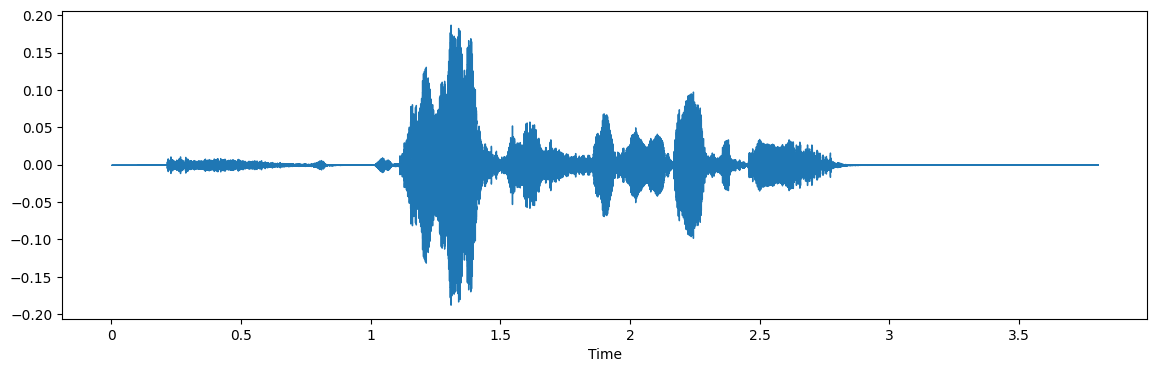

In [28]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

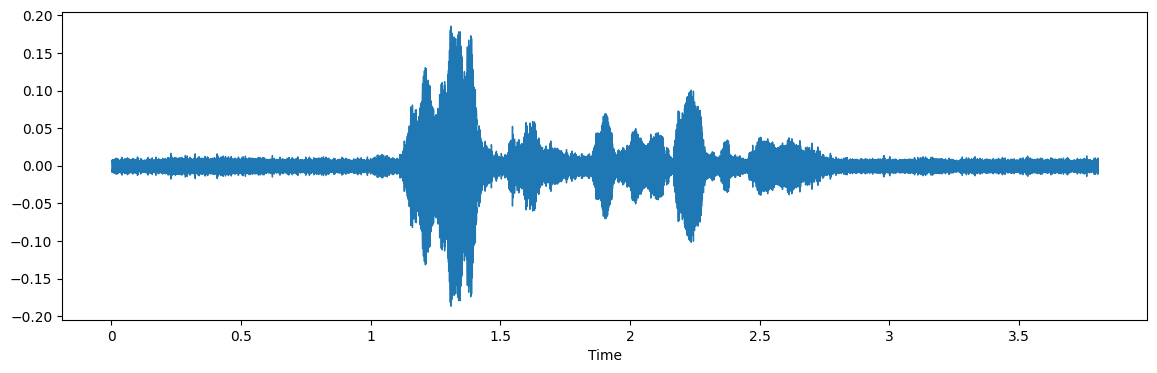

In [29]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

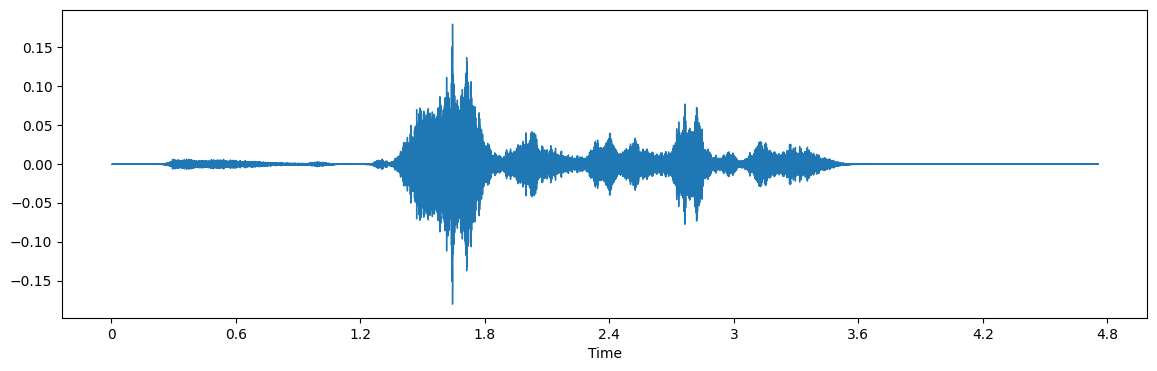

In [30]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

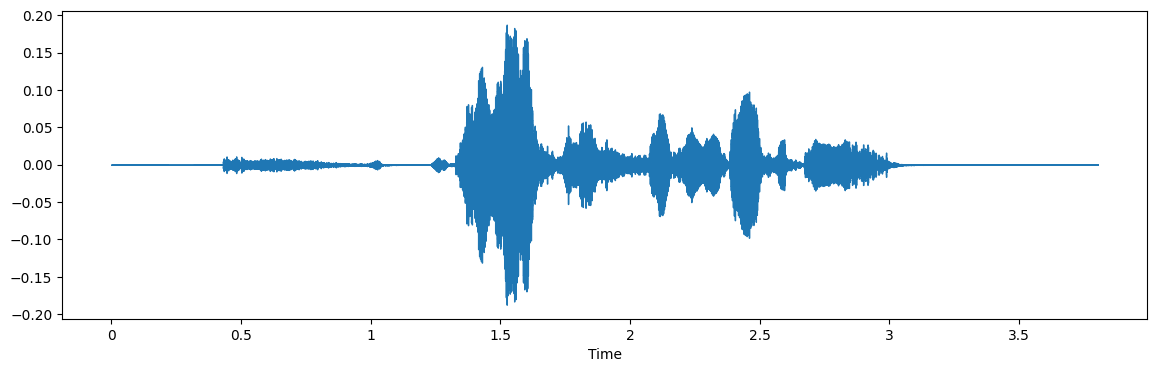

In [31]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

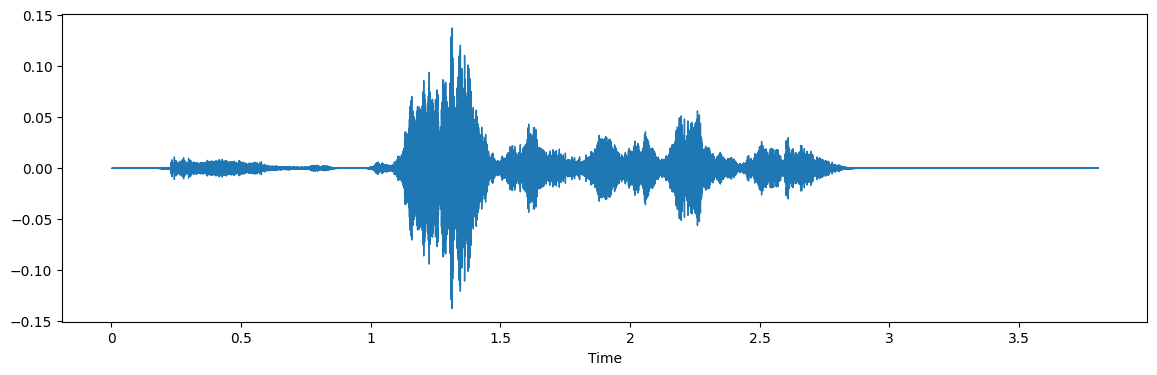

In [32]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Data processing

In [33]:
def load_data(save=False):

    x, y = [], []
    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        # load an audio file as a floating point time series.
        data, sr = librosa.load(file)

        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)

        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]
        y.append(emotion)

        # add noise to the data
        n_data = noise(data)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data)
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)

    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)

    return np.array(x), y



In [34]:
# Chargement des données
X, y = load_data(save=True)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

# Séparation des données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

# x_train et y_train contiennent les données d'entraînement et les étiquettes associées
# x_test et y_test contiennent les données de test et les étiquettes associées


In [35]:
# Initialisation de l'encodeur d'étiquettes
labelencoder = LabelEncoder()

# Apprentissage des classes à partir des données d'entraînement
labelencoder.fit(y_train)

# Création d'un dictionnaire de mappage des noms des classes aux valeurs encodées
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

# Transformation des étiquettes d'entraînement et de test en valeurs encodées
y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)


{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


# Model training

###Définir la structure du modèle


In [36]:

model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
) # 7th layer
model.add(Activation('softmax'))


In [37]:


# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Apply the learning rate schedule to the optimizer
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


## Démarrer l'Entraînement du Modèle

In [38]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

Epoch 1/100
51/51 [==============================] - 7s 27ms/step - loss: 2.3568 - accuracy: 0.2043 - val_loss: 1.9379 - val_accuracy: 0.3204
Epoch 2/100
51/51 [==============================] - 1s 10ms/step - loss: 1.9357 - accuracy: 0.2960 - val_loss: 1.8167 - val_accuracy: 0.3685
Epoch 3/100
51/51 [==============================] - 1s 10ms/step - loss: 1.8148 - accuracy: 0.3559 - val_loss: 1.7142 - val_accuracy: 0.4250
Epoch 4/100
51/51 [==============================] - 1s 10ms/step - loss: 1.7479 - accuracy: 0.3861 - val_loss: 1.6540 - val_accuracy: 0.4407
Epoch 5/100
51/51 [==============================] - 1s 10ms/step - loss: 1.6772 - accuracy: 0.4028 - val_loss: 1.6613 - val_accuracy: 0.4296
Epoch 6/100
51/51 [==============================] - 0s 10ms/step - loss: 1.6153 - accuracy: 0.4386 - val_loss: 1.5430 - val_accuracy: 0.4741
Epoch 7/100
51/51 [==============================] - 1s 10ms/step - loss: 1.5418 - accuracy: 0.4679 - val_loss: 1.4826 - val_accuracy: 0.5028
Epoch 

## Évaluation du Modèle


# Plot the learning curve of the model with its accuracy

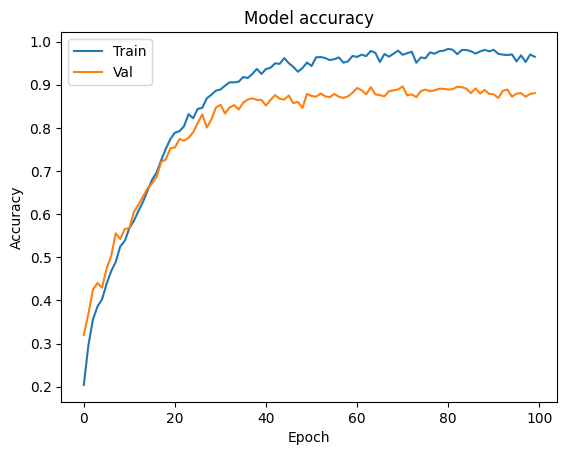

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

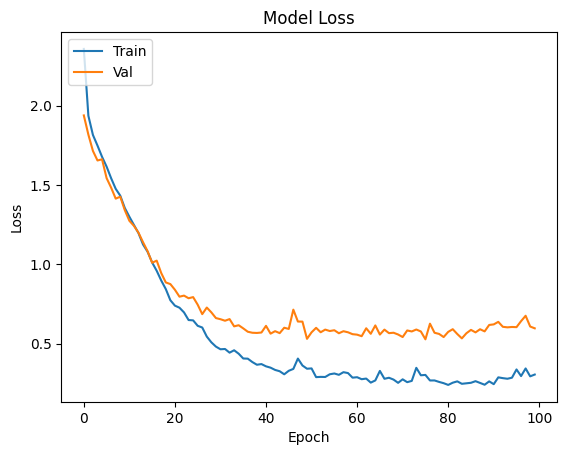

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Use the test data to do prediction



In [41]:
y_pred = model.predict(XTestProcessed)


34/34 [==============================] - 0s 5ms/step


## Draw a confusion matrix



<Axes: >

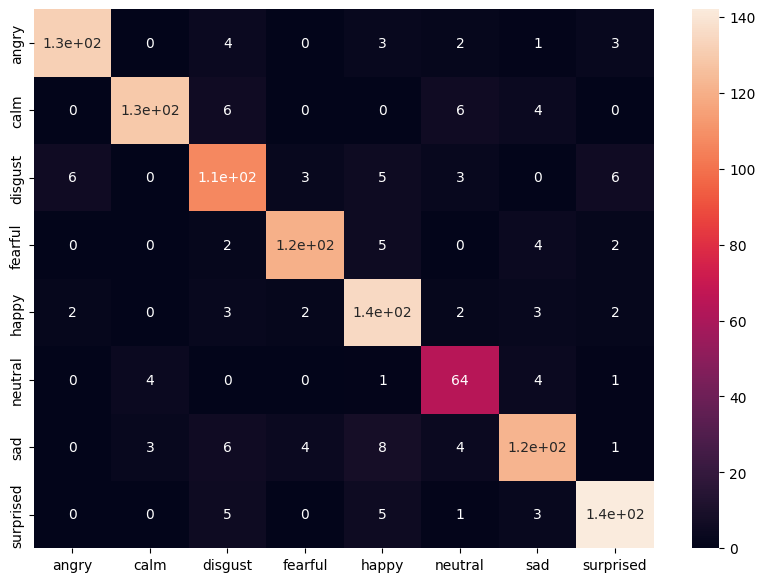

In [42]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)



*   precision  
*   recall  
*   f1-score  
*   Mc





In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Obtenir les prédictions pour les données de test
predictions = model.predict(XTestProcessed)
predicted_classes = np.argmax(predictions, axis=-1)  # Convertir les probabilités en classes

# Afficher le rapport de classification
print(classification_report(y_test, predicted_classes))

# Afficher la matrice de confusion
print(confusion_matrix(y_test, predicted_classes))


34/34 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       145
           1       0.95      0.89      0.92       145
           2       0.80      0.82      0.81       130
           3       0.93      0.90      0.92       133
           4       0.83      0.91      0.87       149
           5       0.78      0.86      0.82        74
           6       0.87      0.82      0.84       148
           7       0.90      0.91      0.91       156

    accuracy                           0.88      1080
   macro avg       0.88      0.88      0.88      1080
weighted avg       0.88      0.88      0.88      1080

[[132   0   4   0   3   2   1   3]
 [  0 129   6   0   0   6   4   0]
 [  6   0 107   3   5   3   0   6]
 [  0   0   2 120   5   0   4   2]
 [  2   0   3   2 135   2   3   2]
 [  0   4   0   0   1  64   4   1]
 [  0   3   6   4   8   4 122   1]
 [  0   0   5   0   5   1   3 142]]



# Model summary




In [44]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 180, 256)          1536      
                                                                 
 activation (Activation)     (None, 180, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 180, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 180, 128)          0         
                                                                 
 dropout (Dropout)           (None, 180, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 22, 128)           0         
 D)                                                              
                                                        

# Save and load the trained model

In [45]:
if not os.path.exists('models'):
    os.makedirs('models')

model.save("models/cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
# Load the model from disk
loaded_model = keras.models.load_model("models/cnn.h5")

# test

In [47]:

def load_single_data(file):
    """
    Charge les données audio et extrait les caractéristiques.

    Args:
        file (str): Chemin du fichier audio.

    Returns:
        tuple: Caractéristiques extraites et étiquettes associées.
    """
    x, y = [], []
    file_name = os.path.basename(file)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file, sr=None)  # Charger le fichier avec le taux d'échantillonnage d'origine
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    return np.array(x), y

# Exemple d'appel de la fonction
XX, yy = load_single_data("/content/emotion_classification/Actor_01/03-01-01-01-02-01-01.wav")


In [48]:
XX, yy = load_single_data("/content/emotion_classification/Actor_01/03-01-01-01-02-01-01.wav")


In [49]:
yy

['neutral']